In [319]:
#Import all the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score, precision_score,
    recall_score, roc_curve
)

In [226]:
# Load metadata again to align with expression matrix
df_meta = pd.read_csv("metadata.csv")
df_expr = pd.read_csv('abundance_ProteinGroups.csv')
# Clean and prepare metadata
df_meta.columns = df_meta.columns.str.strip()
df_meta = df_meta[['sample', 'BCC proliferation']].dropna()

In [227]:
# Extract only intensity columns and transpose to match samples as rows
df_intensity = df_expr.drop(columns=['Protein IDs', 'Protein names', 'Gene names']).transpose()
df_intensity.columns = df_expr['Gene names']
df_intensity.index.name = 'sample'
df_intensity.reset_index(inplace=True)

In [228]:
# Merge with metadata using sample as key
df_merged = pd.merge(df_meta, df_intensity, on='sample')

In [212]:
# Check merged dataset shape
df_merged.shape

(39, 3831)

SPLIT DATASET

In [276]:
#define axis and make all features name into string
X = df_merged.drop(columns=['sample', 'BCC proliferation'])
X.columns = X.columns.astype(str)
y = df_merged['BCC proliferation']

RANDOM FOREST REGRESSION

In [296]:
rf_params = {
    'n_estimators': [20, 50, 100, 150, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 3, 5, 10, 15, 20]
}

In [297]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid=rf_params,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)
best_model_rf = grid_search.best_estimator_

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [298]:
#Print best score
print("Best Params:", grid_search.best_params_)

Best Params: {'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 200}


In [235]:
y_pred_rf = best_model_rf.predict(X)

# Calculate metrics
mse_rf = mean_squared_error(y, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y, y_pred_rf)
mae_rf = mean_absolute_error(y, y_pred_rf)

print(f'Random Forest - Mean Squared Error (MSE): {mse_rf:.4f}')
print(f'Random Forest - Root Mean Squared Error (RMSE): {rmse_rf:.4f}')
print(f'Random Forest - R² Score: {r2_rf:.4f}')
print(f'Random Forest - Mean Absolute Error (MAE): {mae_rf:.4f}')

Random Forest - Mean Squared Error (MSE): 0.0895
Random Forest - Root Mean Squared Error (RMSE): 0.2992
Random Forest - R² Score: 0.6187
Random Forest - Mean Absolute Error (MAE): 0.2258


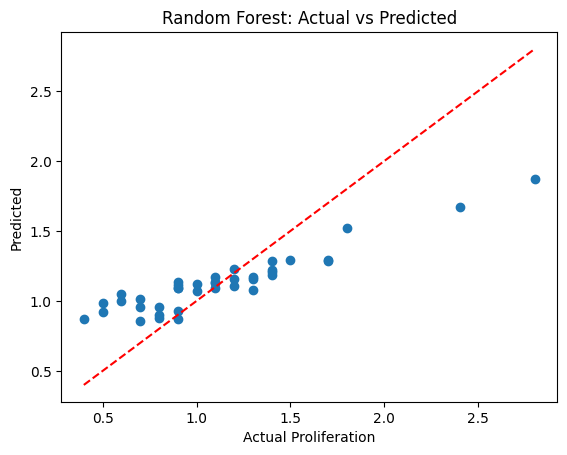

In [312]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred_rf)
plt.xlabel("Actual Proliferation")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()


In [313]:
# Extract non-zero feature importances
all_features_RF = pd.Series(best_model_rf.feature_importances_, index=X.columns)
deps_full_RF = all_features_RF[all_features_RF > 0].sort_values(ascending=False)

# Save full DEP list
deps_full_RF.to_csv("full_RF_feature_importances.csv", header=['Importance'])

# Show number of DEPs and preview top ones
deps_full_RF.shape[0], deps_full_RF.head()

(161,
 STC2      0.071048
 BZW1      0.051359
 ELMOD2    0.029670
 STX5      0.027759
 LRSAM1    0.023504
 dtype: float64)

In [317]:
#Extract HC >0.7
#load TSV file got from STRING PPI
PPI_RF_DEPs = pd.read_csv("PPI_RF_Interations.tsv", sep="\t")
print(f"Total interactions: {len(PPI_RF_DEPs)}")

FileNotFoundError: [Errno 2] No such file or directory: 'PPI_RF_Interations.tsv'

LOGISTIC REGRESSION

In [236]:
#Select Params
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # L2 regularization strength

ridge = Ridge(max_iter=10000)
grid_search_ridge = GridSearchCV(
    ridge, param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1
)

grid_search_ridge.fit(X, y)
best_lr = grid_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=8.8649e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


In [237]:
y_pred_lr = best_lr.predict(X)

mse_lr = mean_squared_error(y, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y, y_pred_lr)
r2_lr = r2_score(y, y_pred_lr)

print("Best Alpha:", grid_search_ridge.best_params_['alpha'])
print(f"R²: {r2_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")

Best Alpha: 0.01
R²: 0.6187
MSE: 0.0895
RMSE: 0.2992
MAE: 0.2258


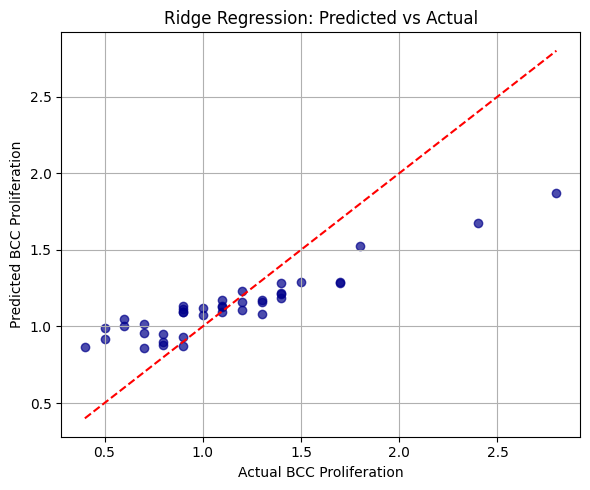

In [238]:
plt.figure(figsize=(6,5))
plt.scatter(y, y_pred_lr, alpha=0.7, color='darkblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual BCC Proliferation")
plt.ylabel("Predicted BCC Proliferation")
plt.title("Ridge Regression: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


SEVERAL MODELS AT THE TIME

In [241]:
model_configs = {
    "ANN (MLP)": {
        "model": MLPRegressor(max_iter=2000, random_state=42),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (30, 10)],
            "alpha": [0.0001, 0.01]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5]
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance'],
            "metric": ['euclidean', 'manhattan']
        }
    }
}

# Store results
regression_results = []

for name, cfg in model_configs.items():
    grid = GridSearchCV(cfg["model"], cfg["params"], scoring="r2", cv=5, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    regression_results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "R²": round(r2, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4)
    })

regression_df = pd.DataFrame(regression_results).sort_values(by="R²", ascending=False)
print(regression_df)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
           Model                                        Best Params  \
1  Decision Tree           {'max_depth': 3, 'min_samples_split': 5}   
2            KNN  {'metric': 'euclidean', 'n_neighbors': 7, 'wei...   
0      ANN (MLP)  {'alpha': 0.0001, 'hidden_layer_sizes': (30, 10)}   

             R²          RMSE          MAE  
1  8.735000e-01  1.723000e-01       0.1414  
2  2.050000e-01  4.320000e-01       0.3139  
0 -5.523089e+13  3.600582e+06  937742.0003  


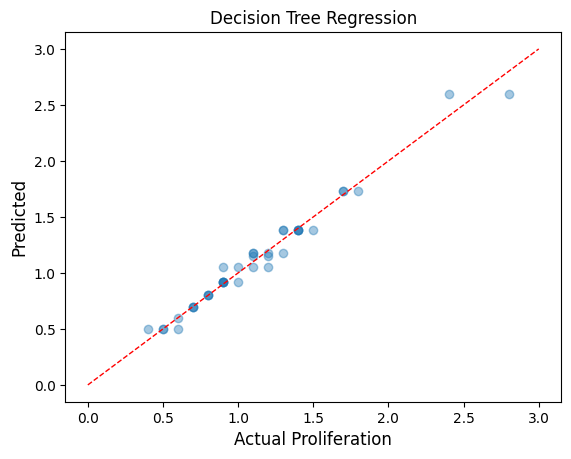

In [311]:
plt.scatter(y, y_pred_reg, alpha=0.4)
plt.xlabel("Actual Proliferation", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.title("Decision Tree Regression")
plt.plot([0, 3], [0, 3], color='red', linestyle='--', lw=1.0)
plt.show()

In [ ]:
EXTRACT ONLY BEST MODEL

In [242]:
import joblib
joblib.dump(best_model, 'decision_tree_regressor.pkl')

['decision_tree_regressor.pkl']

In [293]:
#Classify BCC regression values
np.random.seed(42)
y_binary = (y >= 1.5).astype(int)

dt_reg = DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42)
dt_reg.fit(X, y)

# Predict and threshold
y_pred_reg = dt_reg.predict(X)
threshold = 1.5
y_pred_class = (y_pred_reg >= threshold).astype(int)

# Evaluate classification performance
accuracy = accuracy_score(y_binary, y_pred_class)
auc = roc_auc_score(y_binary, y_pred_reg)
cm = confusion_matrix(y_binary, y_pred_class)

accuracy, auc, cm

(0.9743589743589743,
 np.float64(0.9848484848484848),
 array([[33,  0],
        [ 1,  5]]))

C:\Users\laura\AppData\Local\Temp\ipykernel_4372\3844060315.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=1.5, color='gray')


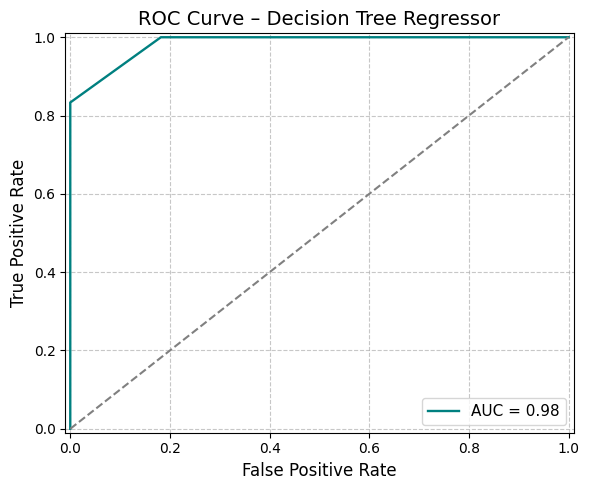

In [294]:
fpr, tpr, _ = roc_curve(y_binary, y_pred_reg)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='teal', lw=1.7, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, color='gray')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve – Decision Tree Regressor", fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

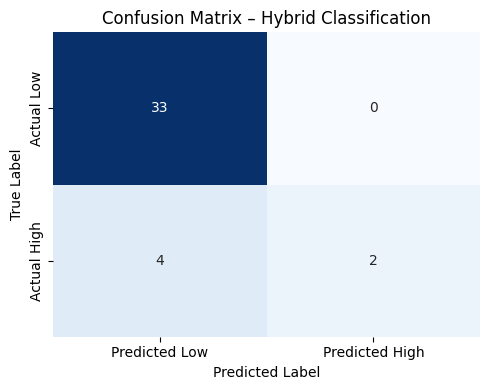

In [291]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title("Confusion Matrix – Hybrid Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [295]:
# Extract non-zero feature importances
all_features = pd.Series(dt_reg.feature_importances_, index=X.columns)
deps_full = all_features[all_features > 0].sort_values(ascending=False)

# Save full DEP list
deps_full.to_csv("full_DT_feature_importances.csv", header=['Importance'])

# Show number of DEPs and preview top ones
deps_full.shape[0], deps_full.head()


(10,
 CYB561D2    0.513253
 ATP6V1B2    0.200117
 SNRPF       0.131046
 PARP1       0.051202
 FCN2        0.040321
 dtype: float64)

LASSO

In [330]:
# Define LASSO model and parameter grid
lasso = Lasso(max_iter=100)
param_grid = {'alpha': [-3, 1, 5, 10, 20, 50, 100]}

# Grid search for best alpha
grid = GridSearchCV(lasso, param_grid, scoring='r2', cv=5)
grid.fit(X, y)

# Best model
best_lasso = grid.best_estimator_

# Predict and evaluate
y_pred_lasso = best_lasso.predict(X)
r2_lasso = r2_score(y, y_pred_lasso)
mse_lasso = mean_squared_error(y, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y, y_pred_lasso)

print("Best Alpha:", grid.best_params_['alpha'])
print(f"R²: {r2_lasso:.4f}")
print(f"RMSE: {rmse_lasso:.4f}")
print(f"MAE: {mae_lasso:.4f}")

C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.865e-04, tolerance: 8.759e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.914e-04, tolerance: 7.694e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\loca

Best Alpha: 50
R²: 1.0000
RMSE: 0.0002
MAE: 0.0002


C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e-03, tolerance: 9.154e-04
  model = cd_fast.enet_coordinate_descent(
